# Data Loading, Preprocessing, and Merging

## 1. Introduction

This notebook focuses on preparing and combining movie data from multiple sources for comprehensive financial success analysis. The main datasets used are:

- CMU Movie Summary Corpus: Contains detailed movie metadata, plot summaries, and character information
- TMDB (The Movie Database): Provides extensive movie metadata including budget and revenue information
- IMDb (Internet Movie Database): Contains comprehensive movie information, ratings, and crew details

The end goal is to create a unified, clean dataset that combines these sources, with properly handled missing values, standardized formats, and inflation-adjusted financial figures. This processed dataset will serve as the foundation for analyzing factors in movie success.

## 2. Imports and Setup

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_directory)

from src.utils.data_utils import (
    load_cmu_movies_data,
    preprocess_cmu_movies_data,
    load_tmdb_data,
    preprocess_tmdb_data,
    load_imdb_data,
    preprocess_imdb_data,
)

from src.utils.merge_utils import (
    merge_cmu_tmdb_data,
    merge_with_imdb_data,
)

from src.utils.general_utils import (
    perform_final_checks,
    adjust_for_inflation,
)

warnings.filterwarnings('ignore')

# change working directory
if os.getcwd().split("/")[-1] != "ada-2024-project-c1n3mada":
    os.chdir("..")

# auto-reload modules
%load_ext autoreload
%autoreload 2

## 3.  Loading the Data

In [4]:
# Set path to data
path = "data/"

# Load CMU Movie Summary Corpus data
df_movies, df_plots, df_characters = load_cmu_movies_data(path)

# Load TMDB data
df_tmdb = load_tmdb_data(path)

# Load IMDb data
df_title_basics, df_title_ratings, df_title_crew, df_name_basics = load_imdb_data(path)

## 4. Initial Exploration

- statistics summary for each dataset
- Missing values
- Basic distributions

In [5]:
# TODO Said's Note: Not sure about this part

# CMU Dataset Overview
print("=== CMU Movies Dataset ===")
print(f"Number of movies: {len(df_movies)}")
print("\nKey statistics for movie runtime and revenue:")
print(df_movies[["movie_runtime", "movie_box_office_revenue"]].describe())
print("\nMissing values:")
print(df_movies.isnull().sum())

# TMDB Dataset Overview
print("\n=== TMDB Dataset ===")
print(f"Number of movies: {len(df_tmdb)}")
print("\nKey statistics for budget and revenue:")
print(df_tmdb[["budget", "revenue"]].describe())
print("\nMissing values in key columns:")
print(df_tmdb[["budget", "revenue", "release_date"]].isnull().sum())

# IMDb Dataset Overview
print("\n=== IMDb Dataset ===")
print(f"Number of titles: {len(df_title_basics)}")
print("\nNumber of Votes distribution:")
print(df_title_ratings["numVotes"].describe())
print("\nRatings distribution:")
print(df_title_ratings["averageRating"].describe())

=== CMU Movies Dataset ===
Number of movies: 81741

Key statistics for movie runtime and revenue:
       movie_runtime  movie_box_office_revenue
count   6.129100e+04              8.401000e+03
mean    1.118192e+02              4.799363e+07
std     4.360070e+03              1.121753e+08
min     0.000000e+00              1.000000e+04
25%     8.100000e+01              2.083193e+06
50%     9.300000e+01              1.063969e+07
75%     1.060000e+02              4.071696e+07
max     1.079281e+06              2.782275e+09

Missing values:
wiki_movie_id                   0
freebase_movie_id               0
movie_name                      0
movie_release_date           6902
movie_box_office_revenue    73340
movie_runtime               20450
movie_languages                 0
movie_countries                 0
movie_genres                    0
dtype: int64

=== TMDB Dataset ===
Number of movies: 45466

Key statistics for budget and revenue:
            revenue
count  4.546000e+04
mean   1.120935e+

## 5. Data Preprocessing

In [6]:
# Preprocess CMU movies data
df_movies, df_characters = preprocess_cmu_movies_data(df_movies, df_characters)

# Preprocess TMDB data
df_tmdb = preprocess_tmdb_data(df_tmdb)

# Preprocess IMDb data (currently no additional preprocessing is applied)
df_title_basics, df_title_ratings, df_title_crew, df_name_basics = preprocess_imdb_data(
    df_title_basics, df_title_ratings, df_title_crew, df_name_basics
)

## 6. Dataset Merging

In [7]:
# Merge CMU movies data with TMDB data
df_movies_merged = merge_cmu_tmdb_data(df_movies, df_tmdb)

# Merge with IMDb data
df_movies_combined = merge_with_imdb_data(
    df_movies_merged, df_title_basics, df_title_ratings, df_title_crew, df_name_basics
)

## 7. Dataset Cleaning

In [8]:
# drop the rows with missing values in the combined_revenue column
df_movies_combined = df_movies_combined.dropna(subset=["combined_revenue"])

# remove the rows that have a revenue of less than 1000 (most likely incorrect data)
df_movies_combined = df_movies_combined[df_movies_combined["combined_revenue"] > 1000]

# Fill missing values with 0 or 'Unknown' (better imputation may be needed)
df_movies_combined["averageRating"].fillna(0, inplace=True)
df_movies_combined["numVotes"].fillna(0, inplace=True)
df_movies_combined["director"].fillna("Unknown", inplace=True)


print(
    "Missing values in averageRating column after merge:",
    df_movies_combined["averageRating"].isnull().sum(),
)
print(
    "Missing values in numVotes column after merge:",
    df_movies_combined["numVotes"].isnull().sum(),
)
print(
    "Missing values in director column after merge:",
    df_movies_combined["director"].isnull().sum(),
)

Missing values in averageRating column after merge: 0
Missing values in numVotes column after merge: 0
Missing values in director column after merge: 0


## 8. Inflation correction

### 8.1 Load CPI (Consumer Price Index) Data

In [ ]:
# Load historical CPI data
df_cpi = pd.read_csv("data/Inflation/CPIAUCNS.csv")

# Convert date to year and calculate yearly average CPI
df_cpi["year"] = pd.to_datetime(df_cpi["observation_date"]).dt.year
cpi = df_cpi[["year", "CPIAUCNS"]].groupby("year").mean().reset_index()

print(f"CPI data ranges from {cpi['year'].min()} to {cpi['year'].max()}")

CPI data ranges from 1913 to 2024


### 8.2 Handle Pre-CPI Data

In [9]:
# Check for movies older than available CPI data
pre_cpi_movies = df_movies_combined[
    df_movies_combined["release_year"] < cpi["year"].min()
]
if not pre_cpi_movies.empty:
    print(
        f"Found {len(pre_cpi_movies)} movies released before {cpi['year'].min()} (earliest CPI data)"
    )
    print("Removing these movies as inflation adjustment wouldn't be accurate")
    df_movies_combined = df_movies_combined[
        df_movies_combined["release_year"] >= cpi["year"].min()
    ]

Found 1 movies released before 1913 (earliest CPI data)
Removing these movies as inflation adjustment wouldn't be accurate


### 8.3 Inflation Adjustment Function

In [10]:
# Apply inflation adjustment
target_year = int(df_movies_combined["release_year"].max())
df_movies_combined = adjust_for_inflation(df_movies_combined, cpi, target_year)

print(f"Revenues adjusted to {target_year} dollars")

Revenues adjusted to 2016 dollars


### 8.4 Verification Plot

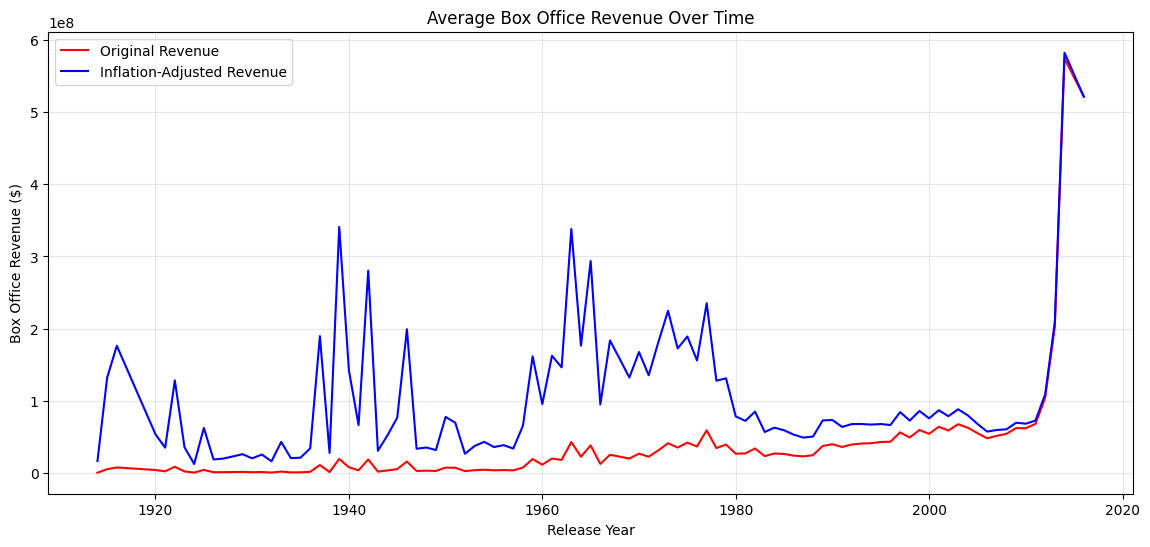


Summary Statistics:
Original Revenue Mean: $45,567,454.24
Inflation-Adjusted Revenue Mean: $77,204,274.43
Inflation Adjustment Factor Range: 1.69x


In [11]:
plt.figure(figsize=(14, 6))

# Calculate yearly averages
yearly_avg = df_movies_combined.groupby("release_year")["combined_revenue"].mean()
yearly_inflated_avg = df_movies_combined.groupby("release_year")[
    "inflated_revenue"
].mean()

# Plot both original and inflation-adjusted revenues
sns.lineplot(
    x=yearly_avg.index, y=yearly_avg.values, color="red", label="Original Revenue"
)
sns.lineplot(
    x=yearly_inflated_avg.index,
    y=yearly_inflated_avg.values,
    color="blue",
    label="Inflation-Adjusted Revenue",
)

plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Release Year")
plt.ylabel("Box Office Revenue ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Original Revenue Mean: ${df_movies_combined['combined_revenue'].mean():,.2f}")
print(
    f"Inflation-Adjusted Revenue Mean: ${df_movies_combined['inflated_revenue'].mean():,.2f}"
)
print(
    f"Inflation Adjustment Factor Range: {df_movies_combined['inflated_revenue'].mean() / df_movies_combined['combined_revenue'].mean():.2f}x"
)

## 9. Final Checks and Export

### 9.1 Data Quality Checks

In [12]:
# Perform final validation checks
checks_passed = perform_final_checks(df_movies_combined)

Performing final data quality checks...

All checks passed! Dataset summary:
Total number of movies: 9,579
Date range: 1914 to 2016
Average inflation-adjusted revenue: $77,204,274.43
Number of unique genres: 318


### 9.2 Data Export

In [ ]:
if checks_passed:
    # Create output directory if it doesn't exist
    output_dir = "data/processed/"
    os.makedirs(output_dir, exist_ok=True)

    # Export to CSV
    output_path = f"{output_dir}movies_processed_new.csv"
    df_movies_combined.to_csv(output_path, index=False)
else:
    raise ValueError("Final validation checks failed. Please review the data.")